<a id='home'></a>
### purpose

estimate RONA for future envs

### outline

1. [get population data](#popdata)
    - just need lat/long and pop names, a list of envs, and elevation data.
1. [get snp data](#snps)
1. [get future climate data](#future)
    - extract population-level future climate data
1. [determine environmental factors ($EF_{future}$) to use to project RONA](#factors)
1. [calculate RONA elements](#elem)
1. [calculate RONA](#rona)
1. [save output](#save)

In [1]:
from pythonimports import *
from myfigs import slope_graph, create_cmap, gradient_image, save_pdf

import seaborn as sns
from scipy.stats import ttest_rel
from IPython.display import Image

# outfiles from ../09_RONA.ipynb
ronadir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/rona'

lview, dview = get_client(targets=range(25))  # use only 25 engines

latest_commit()
session_info.show()

25 25
##################################################################
Current commit of pythonimports:
commit 9f2b6d7984dd7a121d365ff406e02c14cafd5560  
Author: Brandon Lind <brandon.lind@ubc.ca>  
Date:   Fri Apr 22 13:34:17 2022 -0600
Today:	May 19, 2022 - 08:41:49
python version: 3.8.5
##################################################################



<a id='popdata'></a>
# 1. get population data

[top](#home)

In [2]:
# from ../09_RONA.ipynb
snpfiles = {
    'jp' : '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt',
    'fdi' : '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/interior_variety_without-p6/03_maf-p05_RD-recalculated_FDI/DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt',
    'fdc' : '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt',
    'combined' : '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/combined_varieties/03_maf-p05_RD-recalculated_both/DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt'
}

In [3]:
# from ../09_RONA.ipynb
envfiles = {
    'jp' : '/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt',
    'fdi' : '/data/projects/pool_seq/environemental_data/change_p6/df_interior-naturalpops_raw_env-19variables_change-p6.txt',
    'fdc' : '/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_raw_env-19variables_change-p6.txt',
    'combined' : '/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt'
}

In [4]:
# doug-fir pop colors
df_colors = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
df_colors.loc[df_colors['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'  # as in ../01_split_training_and_testing.ipynb
color_dict = dict(zip(df_colors['our_id'], df_colors['group_color']))

In [5]:
# read in the envdata, apply pop colors
envdata = {}
all_colors = {}
for spp,f in envfiles.items():
    envdata[spp] = pd.read_table(f)
    envdata[spp].index = envdata[spp]['our_id'].tolist()
    if spp != 'jp':
        envdata[spp]['group_color'] = envdata[spp]['our_id'].map(color_dict)
    all_colors[spp] = dict(zip(envdata[spp]['our_id'], envdata[spp]['group_color']))
    print(ColorText(spp).bold())
    display(envdata[spp].head())

jp


,id1,id2,our_id,LAT,LONG,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group_color
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,21.2,181,1273,2217,-46.0,34.7,534,103,461,-0.2,-20.1,305,16.6,149,129,54.4,36.7,148,251,green
JP_p73,3273,22,JP_p73,44.4200,-84.6800,359,22.0,241,1956,835,-34.1,36.6,745,131,732,6.1,-8.0,395,19.8,163,140,50.0,27.8,141,271,blue
JP_p97,8060006,37,JP_p97,56.1167,-116.9167,636,23.5,242,1188,2009,-44.3,34.8,556,90,432,0.2,-19.8,272,15.4,138,133,56.5,35.1,151,241,green
JP_p60,3260,17,JP_p60,46.7200,-84.3900,203,16.5,135,1557,1116,-36.8,34.3,599,123,848,4.0,-10.7,397,17.6,156,265,44.2,28.3,147,271,blue
JP_p100,9040116,40,JP_p100,55.7667,-97.8167,205,13.3,130,1003,2956,-49.7,35.2,448,82,506,-3.3,-24.9,315,15.7,106,191,49.9,40.6,163,245,green


fdi


,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,group,group_color
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,1.6,13.4,-10.7,24.1,630,321,18.5,41.8,1242,929,130,171,244,73,261,-43.3,32.6,548,151,Eastern BC,#22ff00
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,3.9,15.3,-9.2,24.5,423,196,32.9,78.2,919,1270,158,154,255,101,149,-40.2,34.9,598,350,North BC,#f205f4
DF_p5,5,DF_p5,FDI,-119.05,49.02,853,6.0,17.7,-6.2,23.9,367,171,43.8,103.6,637,1650,182,142,265,123,100,-34.8,37.7,732,497,Tri-state,#995bbe
DF_p7,7,DF_p7,FDI,-122.13,53.98,684,3.4,15.0,-10.3,25.3,880,341,15.2,43.9,1031,1239,162,150,256,106,372,-40.5,33.6,552,174,North BC,#f205f4
DF_p8,8,DF_p8,FDI,-124.38,54.35,850,2.1,13.7,-11.3,25.0,572,235,21.1,58.4,1210,991,143,164,250,86,262,-42.3,32.4,521,240,North BC,#f205f4


fdc


,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,group,group_color
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,8.4,15.6,2.3,13.3,4004,778,4.6,20.0,143,1644,277,115,301,186,242,-18.3,33.3,606,10,Western BC,#a6cee3
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,6.1,16.4,-4.4,20.8,1029,225,15.6,73.0,518,1521,202,135,272,137,330,-30.9,35.2,659,307,Lower Mainland,#33a02c
DF_p6,6,DF_p6,FDC,-125.75,52.28,460,5.1,15.8,-7.3,23.2,827,180,18.2,87.8,741,1440,172,149,257,108,351,-38.4,35.0,667,392,Western BC,#a6cee3
DF_p10,10,DF_p10,FDC,-125.33,50.00,152,8.3,16.6,0.9,15.7,1502,301,12.2,55.0,182,1727,265,116,294,178,128,-20.5,34.8,651,192,Western BC,#a6cee3
DF_p11,11,DF_p11,FDC,-123.97,48.95,732,5.8,14.4,-1.1,15.5,2204,301,7.2,47.9,336,1203,225,133,286,153,547,-24.1,32.5,529,149,Western BC,#a6cee3


combined


,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD,group_color
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,8.4,15.6,2.3,13.3,4004,778,4.6,20.0,143,1644,277,115,301,186,242,-18.3,33.3,606,10,#a6cee3
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,6.1,16.4,-4.4,20.8,1029,225,15.6,73.0,518,1521,202,135,272,137,330,-30.9,35.2,659,307,#33a02c
DF_p3,3,DF_p3,FDI,-115.62,50.54,1525,1.6,13.4,-10.7,24.1,630,321,18.5,41.8,1242,929,130,171,244,73,261,-43.3,32.6,548,151,#22ff00
DF_p4,4,DF_p4,FDI,-122.33,52.04,900,3.9,15.3,-9.2,24.5,423,196,32.9,78.2,919,1270,158,154,255,101,149,-40.2,34.9,598,350,#f205f4
DF_p5,5,DF_p5,FDI,-119.05,49.02,853,6.0,17.7,-6.2,23.9,367,171,43.8,103.6,637,1650,182,142,265,123,100,-34.8,37.7,732,497,#995bbe


In [6]:
envs = envdata['combined'].columns[-21:-1]
print(len(envs))
envs

20


Index(['Elevation', 'MAT', 'MWMT', 'MCMT', 'TD', 'MAP', 'MSP', 'AHM', 'SHM',
       'DD_0', 'DD5', 'NFFD', 'bFFP', 'eFFP', 'FFP', 'PAS', 'EMT', 'EXT',
       'Eref', 'CMD'],
      dtype='object')

<a id='snps'></a>
# 2. get snp sets

as in ../09_RONA.ipynb but just for the real WZA outliers

[top](#home)

In [7]:
# get files that have loci IDs among sets created in ../04_create_datasets-wza_baypass_random.ipynb#outliers
# but just for the real WZA outliers
training_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_files'
files = fs(training_dir, 'full', endswith='.txt', exclude=['envdata', 'wl-'])

len(files)

24

In [8]:
# get the loci that were assigned to testing sets in ../04_create_datasets-wza_baypass_random.ipynb#outliers
    # ie union of random/baypass/wza/psuedo_random sets
# (I want to reduce the time to calculate linear models, only need to do these loci)
spploci = defaultdict(list)
grouploci = wrap_defaultdict(None, 3)
for f in files:
    spp,method,setname,kfold = op.basename(f).rstrip('.txt').split('-')
    
    df = pd.read_table(f, index_col='index', nrows=1)
    # this next line from a previous run where I had accidentally wrote txt with multiple index 
        # (can prob deprecate, but no harm if I leave it)
    loci = [locus for locus in df.columns if 'Unnamed' not in locus and 'level' not in locus]
    
    print(spp, method, setname, len(loci))
    grouploci[spp][method][setname] = loci
    spploci[spp].extend(loci)
    
print('\n')

for spp,loci in spploci.items():
    spploci[spp] = uni(loci)
    print(spp, len(spploci[spp]))

combined baypass pseudo_random_loci 25219
combined baypass random 25219
combined baypass real 25219
combined wza pseudo_random_loci 14760
combined wza random 14760
combined wza real 14760
fdc baypass pseudo_random_loci 17516
fdc baypass random 17516
fdc baypass real 17516
fdc wza pseudo_random_loci 4886
fdc wza random 4886
fdc wza real 4886
fdi baypass pseudo_random_loci 12398
fdi baypass random 12398
fdi baypass real 12398
fdi wza pseudo_random_loci 11434
fdi wza random 11434
fdi wza real 11434
jp baypass pseudo_random_loci 22635
jp baypass random 22635
jp baypass real 22635
jp wza pseudo_random_loci 4788
jp wza random 4788
jp wza real 4788


combined 114396
fdc 64714
fdi 68488
jp 76320


<a id='future'></a>
# 3. get future climate data

[top](#home)

In [9]:
# functions from ../11_validate_GF_offset_predictions.ipynb
# modified for readability (eg "offset" -> "future") 
    # - also replacing latitude/longitude with lat/lon because of the way ...
        # ... I saved WGS84 projected data in ../03_clip_climate_data.ipynb

def read_future_file(future_file, x_dim="latitude", y_dim="longitude"):
    """Read in netcdf file."""
    import xarray as xr
    import rioxarray

    ds = xr.open_dataset(future_file)
    ds.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
#     layers = [var for var in list(ds.variables) if var not in ['crs', 'longitude', 'latitude']]
    layers = [var for var in list(ds.variables) if var not in ['crs', x_dim, y_dim]]
    assert len(layers) == 1
    
    layer = layers[0]
    vals = ds[layer][:,:]
#     lons = ds[layer]['longitude']
    lons = ds[layer][x_dim]
#     lats = ds[layer]['latitude']
    lats = ds[layer][y_dim]
    
    return ds, layer, vals, lons, lats


# def get_offset_data(offset_file, envdata, latcol='LAT', loncol='LONG'):
def get_future_data(future_file, envdata, latcol='LAT', loncol='LONG', **kwargs):
    """Read in offset data from netCDF `future_file` for each of the pops in `envdata`."""
    import xarray as xr

    # read in offset data
    ds,layer,*args = read_future_file(future_file, **kwargs)

    # pull offset values directly from the shapefile
    target_lat = xr.DataArray(envdata[latcol], dims='points')
    target_lon = xr.DataArray(envdata[loncol], dims='points')
#     future_clim = ds[layer].sel(longitude=target_lon, latitude=target_lat, method='nearest').to_dataframe()
    future_clim = ds[layer].sel(lon=target_lon, lat=target_lat, method='nearest').to_dataframe()
    future_clim.index = envdata['our_id'].tolist()
    
    try:
        assert future_clim[future_clim.columns[-1]].isnull().sum() == 0
    except AssertionError as e:
        # there can be null vals if a population resides outside of the shapefile boundaries ...
        # ... when shapefiles have been used to clip climate data
        print(future_file, envdata.index)
        raise e

    return future_clim

In [10]:
envs

Index(['Elevation', 'MAT', 'MWMT', 'MCMT', 'TD', 'MAP', 'MSP', 'AHM', 'SHM',
       'DD_0', 'DD5', 'NFFD', 'bFFP', 'eFFP', 'FFP', 'PAS', 'EMT', 'EXT',
       'Eref', 'CMD'],
      dtype='object')

In [11]:
# read in future climates

netcdf_dir = '/data/projects/pool_seq/environemental_data/new_netCDF_files'
rcpdirs = fs(netcdf_dir, pattern='NA_ENSEMBLE_rcp', dirs=True)

future_envs = wrap_defaultdict(None, 3)
for d in rcpdirs:
    rcp = op.basename(d)
            
    for env in pbar(envs, desc=rcp):
        if env == 'Elevation':  # elevation won't change too much, yuh know, so I don't need to test it
            continue
            
        nc = op.join(d, f'{env}_WGS84.nc')
        
        for spp,envdf in envdata.items():
            future_envs[spp][rcp][env] = get_future_data(nc, envdf, x_dim='lon', y_dim='lat')['Band1']

# combine envs to dataframe
future_clim = wrap_defaultdict(None, 2)
for spp,rcpdict in future_envs.items():
    for rcp,envdict in rcpdict.items():
        future_clim[spp][rcp] = pd.DataFrame(envdict)

# show example
print(spp, rcp)
future_clim[spp][rcp].head()

NA_ENSEMBLE_rcp85_2080s: 100%|███████████████| 20/20 [00:09<00:00,  2.15it/s]

combined NA_ENSEMBLE_rcp85_2080s


,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,13.5,21.1,7.5,13.600000,4076.0,663.0,5.800000,31.799999,33.0,3153.0,354.0,23.0,348.0,326.0,27.0,-5.8,38.299999,707.0,86.0
DF_p2,11.9,23.6,0.7,22.900000,1064.0,196.0,20.600000,120.300003,158.0,2925.0,297.0,88.0,309.0,221.0,75.0,-19.1,42.299999,855.0,484.0
DF_p3,8.4,21.6,-4.7,26.299999,454.0,206.0,40.599998,104.599998,472.0,2312.0,214.0,120.0,279.0,159.0,84.0,-32.5,41.599998,797.0,481.0
DF_p4,9.1,21.6,-3.9,25.500000,472.0,190.0,40.599998,113.500000,385.0,2366.0,232.0,113.0,284.0,171.0,81.0,-30.6,41.500000,785.0,480.0
DF_p5,10.5,23.4,-1.3,24.700001,391.0,154.0,52.500000,152.000000,249.0,2640.0,249.0,113.0,292.0,179.0,40.0,-25.6,43.400002,876.0,608.0


<a id='factors'></a>
# 4. determine environmental factors ($EF_{future}$) to use to validate RONA]

[top](#home)

In [12]:
# get p-values from paired t tests
    # as in ../09_RONA.ipynb
ef_futs = wrap_defaultdict(None, 3)
for spp,envdf in envdata.items():
    for rcp,futdata in future_clim[spp].items():
        for env in envs:
            if env == 'Elevation':
                continue
            t,p = ttest_rel(futdata[env], envdf[env])
            ef_futs[spp][rcp][env] = p
            

In [13]:
# show top 5 envs (sorted by p-value) for each spp for each rcp
canonical_efs = defaultdict(dict)
for spp,rcpdict in ef_futs.items():
    for rcp,pdict in rcpdict.items():
        print(ColorText(f'{spp} {rcp}').bold().blue())
        # get top 5 environments with lowest p-values
        df = pd.DataFrame(pdict, index=[rcp]) \
            .T \
            .sort_values(by=rcp, ascending=True) \
            .iloc[:5]
        
        canonical_efs[spp][rcp] = df.index.tolist()
        display(df)
        
canonical_efs[spp][rcp]

jp NA_ENSEMBLE_rcp45_2050s


,NA_ENSEMBLE_rcp45_2050s
MWMT,2.875117e-47
MAT,1.149539e-46
MCMT,4.030386e-43
eFFP,5.195349e-39
FFP,2.351482e-38


jp NA_ENSEMBLE_rcp45_2080s


,NA_ENSEMBLE_rcp45_2080s
MWMT,9.972530e-50
MAT,2.062680e-48
MCMT,9.965187e-45
FFP,2.777961e-41
eFFP,5.246848e-41


jp NA_ENSEMBLE_rcp85_2050s


,NA_ENSEMBLE_rcp85_2050s
MWMT,2.787246e-50
MAT,5.411064e-49
MCMT,1.609826e-43
FFP,1.936372e-43
eFFP,1.179592e-41


jp NA_ENSEMBLE_rcp85_2080s


,NA_ENSEMBLE_rcp85_2080s
MWMT,6.989634e-54
FFP,1.501570e-52
MAT,1.374590e-49
bFFP,1.413493e-48
eFFP,8.371713e-48


fdi NA_ENSEMBLE_rcp45_2050s


,NA_ENSEMBLE_rcp45_2050s
EMT,6.283975e-26
FFP,1.764289e-25
eFFP,1.921425e-25
MCMT,3.070355e-25
bFFP,5.206336e-23


fdi NA_ENSEMBLE_rcp45_2080s


,NA_ENSEMBLE_rcp45_2080s
FFP,1.002901e-28
EMT,4.992371e-28
eFFP,5.882292e-28
MCMT,5.919549e-28
bFFP,5.065937e-26


fdi NA_ENSEMBLE_rcp85_2050s


,NA_ENSEMBLE_rcp85_2050s
eFFP,1.557265e-29
EMT,1.733999e-29
FFP,5.703611e-29
MCMT,4.664706e-28
bFFP,1.861100e-25


fdi NA_ENSEMBLE_rcp85_2080s


,NA_ENSEMBLE_rcp85_2080s
EMT,1.838679e-35
MCMT,1.274962e-34
FFP,8.227596e-34
eFFP,8.277070e-33
bFFP,2.315516e-30


fdc NA_ENSEMBLE_rcp45_2050s


,NA_ENSEMBLE_rcp45_2050s
eFFP,3.284415e-15
MWMT,5.809769e-15
EMT,2.552819e-14
MCMT,1.795920e-13
FFP,4.404064e-13


fdc NA_ENSEMBLE_rcp45_2080s


,NA_ENSEMBLE_rcp45_2080s
MWMT,2.675554e-18
eFFP,5.613724e-18
EMT,1.324191e-16
MCMT,7.747987e-16
FFP,1.795663e-15


fdc NA_ENSEMBLE_rcp85_2050s


,NA_ENSEMBLE_rcp85_2050s
eFFP,4.269417e-19
MWMT,7.415493e-19
EMT,8.232087e-17
MAT,3.458775e-16
MCMT,4.191804e-16


fdc NA_ENSEMBLE_rcp85_2080s


,NA_ENSEMBLE_rcp85_2080s
MWMT,1.057174e-25
eFFP,1.370310e-25
EMT,4.077252e-23
MAT,6.223919e-23
MCMT,1.025166e-22


combined NA_ENSEMBLE_rcp45_2050s


,NA_ENSEMBLE_rcp45_2050s
EMT,4.418921e-34
eFFP,4.956478e-33
MCMT,1.327865e-32
MWMT,8.178151e-31
NFFD,2.224534e-29


combined NA_ENSEMBLE_rcp45_2080s


,NA_ENSEMBLE_rcp45_2080s
EMT,1.044590e-38
eFFP,2.052172e-38
MWMT,5.000273e-37
MCMT,5.916904e-37
NFFD,5.757817e-35


combined NA_ENSEMBLE_rcp85_2050s


,NA_ENSEMBLE_rcp85_2050s
eFFP,2.706708e-41
EMT,1.557749e-39
MWMT,1.610743e-38
MCMT,3.292431e-37
NFFD,4.373807e-36


combined NA_ENSEMBLE_rcp85_2080s


,NA_ENSEMBLE_rcp85_2080s
eFFP,1.715075e-53
EMT,1.169442e-51
MWMT,7.215109e-51
MCMT,5.217827e-48
MAT,1.464057e-47


['eFFP', 'EMT', 'MWMT', 'MCMT', 'MAT']

<a id='elem'></a>
# 5. calculate RONA elements

[top](#home)

In [14]:
# load the linear models relating current allele freqs with current climate data
linear_models = pklload(op.join(ronadir, 'linear_models.pkl'))  # i called this 'results' in ../09_RONA.ipynb

# load the loci with significant linear models
keep = pklload(op.join(ronadir, 'keep.pkl'))


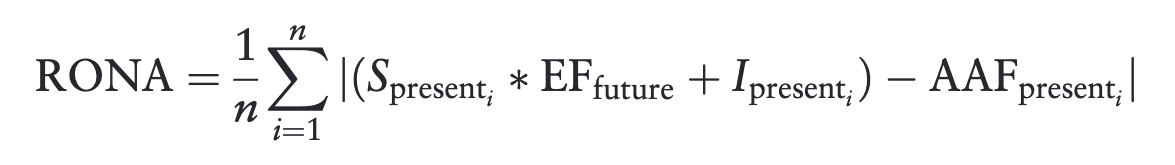

In [15]:
# from Rellstab et al. 2016 
# - this should really be RONA_p_e (RONA is calculated for a single pop for a single environmental variable)
Image(filename='RONA.png') 

In [16]:
# functions from ../09_RONA.ipynb
    # modified for readability (eg garden -> rcp; cgdict -> future_clim)

def calc_rona_elements(spp, rcp, env, pop, aaf_present):
    """Calculate and return the abs element for each of n loci in `aaf_present.index`."""
    ef_fut = future_clim[spp][rcp].loc[pop, env]
    
    rona_elements = {}
    for locus_i in aaf_present.index:
        s_present, i_present, pval = linear_models[spp][env][locus_i]
        # nans can be appended if locus has missing data for that pop, account for this when summing/avging
        rona_elements[locus_i] = abs(
            (s_present * ef_fut) + i_present - aaf_present[pop].loc[locus_i]
        )
    
    return rona_elements
dview['calc_rona_elements'] = calc_rona_elements
dview['linear_models'] = linear_models


def get_rona_elements(freqs, spp=None):
    """Calculate the typical summation element of RONA for loci with siginificant linear models."""
    from pythonimports import wrap_defaultdict
    
    elements = wrap_defaultdict(None, 4)
    for env,loci in keep[spp].items():
        if env == 'Elevation':
            continue
        interloci = set(loci).intersection(freqs.index)
        for rcp in future_clim[spp]:
            for pop in freqs.columns:
                elements[spp][env][rcp][pop] = calc_rona_elements(spp,
                                                                  rcp,
                                                                  env,
                                                                  pop,
                                                                  freqs.loc[interloci])
    return elements
dview['keep'] = dict(keep)
dview['future_clim'] = dict(future_clim)


def frequenize(df, spp=None):
    """Convert allele freq percent to float, reduce loci to those assigned to `spp` in `spploci[spp]`."""
    import pandas 

    locuscol = 'unstitched_locus' if 'unstitched_locus' in df.columns.tolist() else 'locus'
    
    freqcols = [col for col in df.columns if 'FREQ' in col]
    
    df.index = df[locuscol].tolist()
    
    df = df[
        df.index.isin(spploci[spp])
    ]
    
    df = df[freqcols].apply(lambda percent: percent.str.rstrip("%").astype(float)/100, axis=1)
    df.columns = [col.rstrip(".FREQ") for col in df.columns]  # convert to pop names

    return df
dview['spploci'] = spploci


In [17]:
# test function (as in ../09_RONA.ipynb)
spp = 'fdc'

freqs = frequenize(
    pd.read_table(snpfiles[spp], nrows=1000),
    spp
)

output = get_rona_elements(freqs, spp)

output['fdc']['AHM']['NA_ENSEMBLE_rcp45_2050s']['DF_p28']  # note nan from locus/pop combo with missing data

{'jcf7190000000022-98544': 0.08424293825524432, 'jcf7190000000008-430119': nan}

In [18]:
# wait for data to finish loading to engines
sleeping(60)

sleeping: 100%|███████████████| 60/60 [01:00<00:00,  1.00s/it]


In [19]:
# calculate rona elements in parallel
rona_elements = wrap_defaultdict(dict, 4)
for spp, file in snpfiles.items():
    
    # organize functions to call in parallel
    functions = create_fundict(frequenize, kwargs={'spp' : spp})
    functions.update(
        create_fundict(get_rona_elements, kwargs={'spp' : spp})
    )
    
    # calculate rona elements in parallel
    jobs = parallel_read(file,
                         lview=lview,
                         dview=dview,
                         verbose=False,
                         functions=functions,
                         maintain_dataframe=False)
    
    # gather elements
    time.sleep(2)
    for j in pbar(jobs, desc='gathering results'):
        for spp,envdict in j.items():
            for env,rcpdict in envdict.items():
                for rcp,popdict in rcpdict.items():
                    for pop,elementdict in popdict.items():
                        # `elementdict` is returned from `calc_rona_elements` - key=locus, val=summation_element
                        rona_elements[spp][env][rcp][pop].update(elementdict)

# clear memory from engines
client = Client()
_ = client.clear(client.ids)


Watching 25 parallel_read() jobs ...


JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated.txt: 100%|███████████████| 25/25 [01:10<00:00,  2.83s/it]


Function `parallel_read` completed after : 0-00:01:22


gathering results: 100%|███████████████| 25/25 [00:08<00:00,  3.03it/s]



Watching 25 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDI_maf_RD-recalculated.txt: 100%|███████████████| 25/25 [00:42<00:00,  1.69s/it]


Function `parallel_read` completed after : 0-00:00:56


gathering results: 100%|███████████████| 25/25 [00:03<00:00,  7.83it/s]



Watching 25 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated.txt: 100%|███████████████| 25/25 [01:06<00:00,  2.67s/it]


Function `parallel_read` completed after : 0-00:01:20


gathering results: 100%|███████████████| 25/25 [00:05<00:00,  4.78it/s]



Watching 25 parallel_read() jobs ...


DF_pooled-varscan_all_bedfiles_SNP_both-varieties_maf_RD-recalculated.txt: 100%|███████████████| 25/25 [09:06<00:00, 21.86s/it]  


Function `parallel_read` completed after : 0-00:09:24


gathering results: 100%|███████████████| 25/25 [01:35<00:00,  3.82s/it]


<a id='rona'></a>
# 6. calculate rona

[top](#home)

In [20]:
# Calculate the real rona by summing and averaging - separate loci by group

rona = wrap_defaultdict(None, 6)  # one RONA per pop per climate
for spp,envdict in rona_elements.items():
    for env,rcpdict in pbar(envdict.items(), desc=spp):
        for rcp,popdict in rcpdict.items():
            for pop,elementdict in popdict.items():
                # make sure I got what I was expecting to get - number of loci with sig linear models
                assert len(elementdict) == len(keep[spp][env])

                # for each group of loci, calc RONA by according to equation above by 
                    # averaging rona_elements while accounting for missing data
                for method,locus_setdict in grouploci[spp].items():
                    for setname,setloci in locus_setdict.items():
                        # get all of the typical summation elements for loci within `setname` that have sig models
                        interloci = set(setloci).intersection(elementdict.keys())
                        elements = [elementdict[locus] for locus in interloci]
                        if sum(el==el for el in elements) > 0:
                            # if at least one instance of non-np.nan data:
                            _mean = np.nanmean(elements)  # np.nanmean accounts for missing data
                        else:
                            # avoid RuntimeWarning: Mean of empty slice
                            # this happened when a pop had missing data at all of the few number of loci given (eg 2)
                                # and each `el` in `elements` was therefore `np.nan`
                            _mean = np.nan
                        rona[spp][env][rcp][pop][method][setname] = _mean

combined: 100%|███████████████| 19/19 [20:43<00:00, 65.45s/it]


<a id='save'></a>
# save output

[top](#home)

In [21]:
pkl = op.join(ronadir, 'future_rona.pkl')
pkldump(rona, pkl)

pkl

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/rona/future_rona.pkl'

In [22]:
pkl = op.join(ronadir, 'future_efdict.pkl')
pkldump(ef_futs, pkl)

pkl

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/rona/future_efdict.pkl'

In [23]:
pkl = op.join(ronadir, 'canonical_future_efdict.pkl')
pkldump(canonical_efs, pkl)

pkl

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/rona/canonical_future_efdict.pkl'

[top](#home)